<a href="https://colab.research.google.com/github/kozz84/random/blob/main/ATMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

#LOAD FILE AND MERGE INTO ONE DATAFRAME

In [2]:
df= pd.DataFrame()
dir='/content/drive/MyDrive/testcashmanagementdatascientisteuronet/'
for files in os.listdir(dir):
    if files.endswith(".csv"):
        temp = pd.read_csv(dir+files,sep=';',
                       parse_dates=[1],
                       index_col=[1]
                       )
        temp.rename(columns={'Withdrawal':temp['Atm'][0]},inplace=True)
        temp.drop(['Atm'],axis=1,inplace=True)
        df = pd.concat([df, temp], axis=1, join='outer')
df = df.reindex(sorted(df.columns), axis=1)

In [3]:
df.head(5)

,ATM1,ATM2,ATM3,ATM4,ATM5,ATM6,ATM7,ATM8,ATM9
ProcessDate,,,,,,,,,
2017-01-01,NaN,18200,100.0,46690.0,930.0,1400.0,NaN,117730.0,NaN
2017-01-02,31950.0,8790,10580.0,48820.0,5870.0,31120.0,14210.0,85920.0,11410.0
2017-01-03,18800.0,3620,15550.0,25520.0,2750.0,41870.0,20660.0,88720.0,14850.0
2017-01-04,16180.0,3820,8010.0,30290.0,3520.0,37180.0,13400.0,85080.0,10440.0
2017-01-05,39100.0,1590,14690.0,21680.0,NaN,40280.0,17940.0,84110.0,9410.0


Some data is missing. Without backkground information it's hard to choose the imputation method.

In [4]:
df.isna().sum()

ATM1    151
ATM2      0
ATM3      5
ATM4      6
ATM5      4
ATM6      3
ATM7     93
ATM8     16
ATM9     86
dtype: int64

In [5]:
df[df.isna().any(axis=1)]

,ATM1,ATM2,ATM3,ATM4,ATM5,ATM6,ATM7,ATM8,ATM9
ProcessDate,,,,,,,,,
2017-01-01,NaN,18200,100.0,46690.0,930.0,1400.0,NaN,117730.0,NaN
2017-01-05,39100.0,1590,14690.0,21680.0,NaN,40280.0,17940.0,84110.0,9410.0
2017-01-06,NaN,27440,990.0,27190.0,NaN,4030.0,NaN,149760.0,NaN
2017-01-08,NaN,8650,3650.0,12000.0,650.0,25500.0,18290.0,103680.0,11240.0
2017-01-22,NaN,9940,5230.0,39360.0,3150.0,10100.0,2500.0,135150.0,8880.0
...,...,...,...,...,...,...,...,...,...
2019-10-13,NaN,13980,NaN,48120.0,7810.0,18380.0,NaN,860.0,NaN
2019-10-15,48110.0,8850,37680.0,21510.0,15340.0,41260.0,9500.0,NaN,44450.0
2019-10-20,NaN,13030,11100.0,37400.0,6240.0,11190.0,NaN,1790.0,NaN


In [6]:
df.fillna(0,inplace=True)

In [7]:
df.isna().sum()

ATM1    0
ATM2    0
ATM3    0
ATM4    0
ATM5    0
ATM6    0
ATM7    0
ATM8    0
ATM9    0
dtype: int64

#Data Analysis

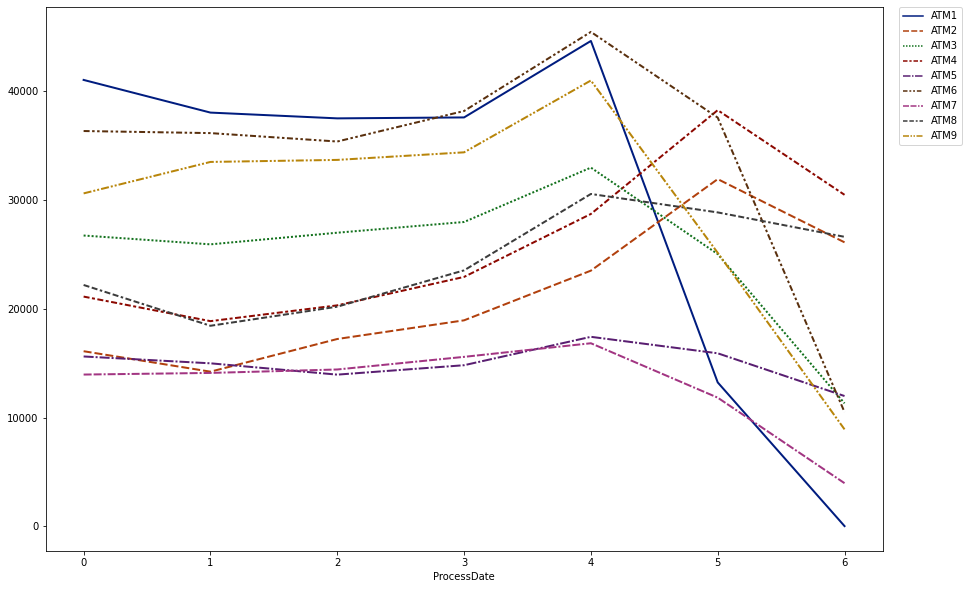

In [8]:
plt.figure(figsize=(15,10))
sns.lineplot(data=df.groupby(df.index.dayofweek).mean(),palette='dark',linewidth=2)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

The vast majority of ATMs show a drop in withdraws on Saturday and Sunday.

Biggest drop can be obsevered in order for ATM1, ATM6,ATM9.

ATM4 and ATM2 show a steady increase from Monday to Saturday.

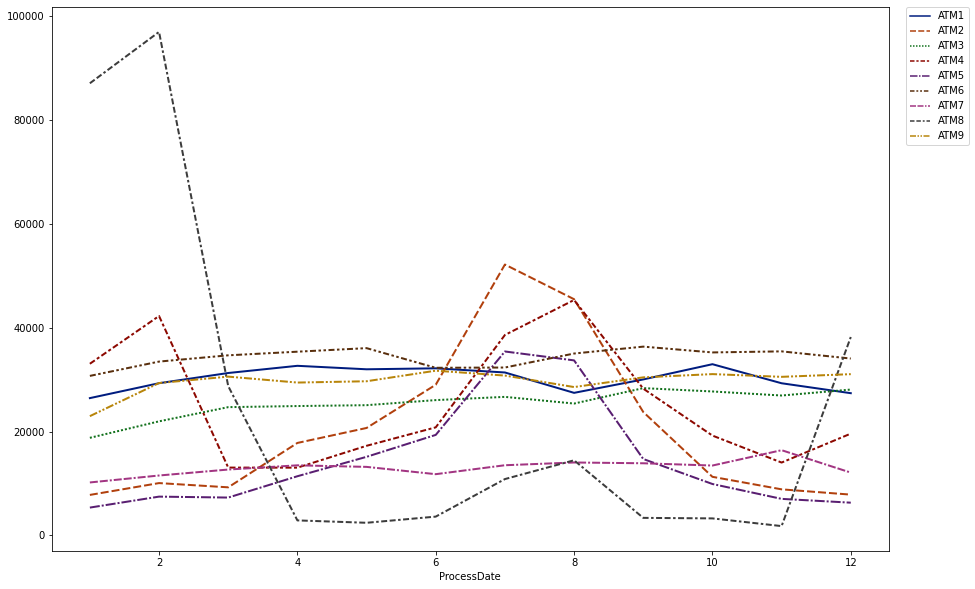

In [9]:
plt.figure(figsize=(15,10))
sns.lineplot(data=df.groupby(df.index.month).mean(),palette='dark',linewidth = 2)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

ATM2, ATM4,ATM5, ATM8 show annual seasonality.

ATM2 and ATM5 show increase in withdraw in July/August.

ATM4 and ATM8 show increase in withdraw in July/August as well as DecemberFebruary.

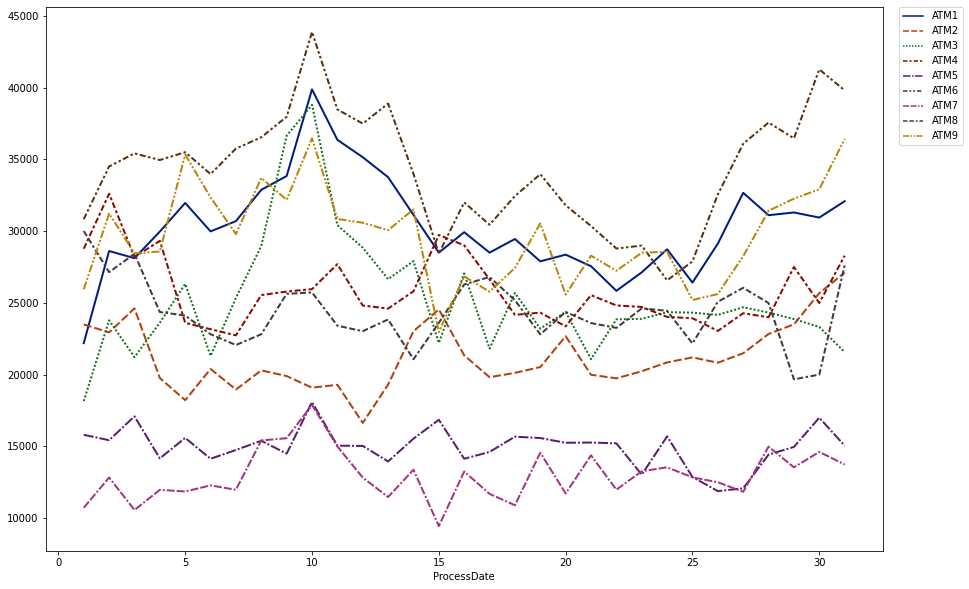

In [10]:
plt.figure(figsize=(15,10))
sns.lineplot(data=df.groupby(df.index.day).mean(),palette='dark',linewidth = 2)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

#Timeseries prediction

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
for i in df.columns:
    results = seasonal_decompose(df[i][0:180],model='additive')
    results.plot();

In [88]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [ ]:
for i in df.columns:
    results = seasonal_decompose(df[i],model='additive')
    results.plot()
    plt.show()

In [103]:
import warnings
warnings.filterwarnings('ignore')

In [139]:
def fitting():
    score = []
    for i in df.columns:
        train = df[i].iloc[:-30]
        test = df[i].iloc[-30:]
        model = ExponentialSmoothing(
                    train,
                    trend='add',
                    seasonal='add',
                    seasonal_periods=7
                     ).fit()
        pred = model.forecast(60)
       #plt.plot(train)
        plt.figure(figsize=(10,5))
        plt.title(i)
        plt.plot(test)
        plt.plot(pred)
        plt.tight_layout()
        #plt.xlim(('2019-08','2019-11'))
        plt.show()
        MAE = mean_absolute_error(pred[0:30],test)
        MSE = mean_squared_error(pred[0:30],test)
        score.append([i,MAE,MSE])
    score = pd.DataFrame(score, columns=['ATM', 'MAE','MSE'])
    return score
        

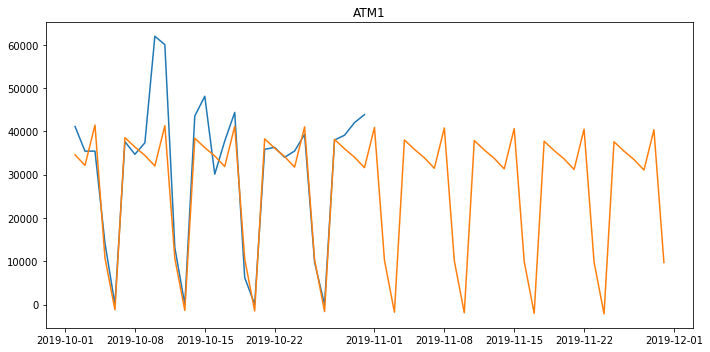

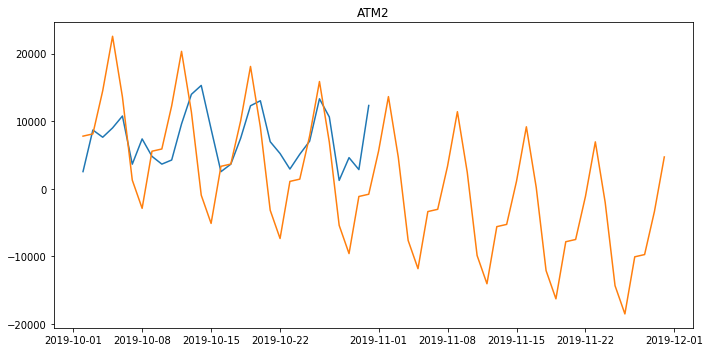

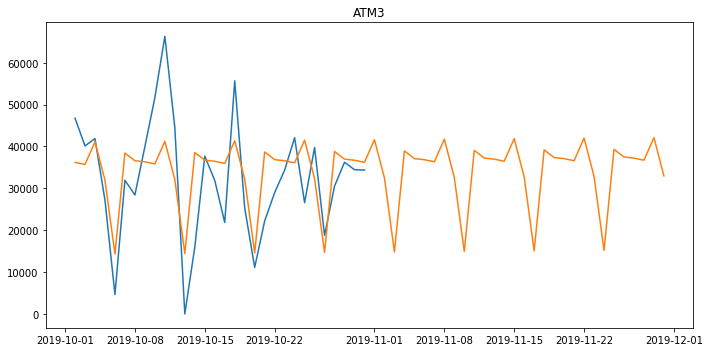

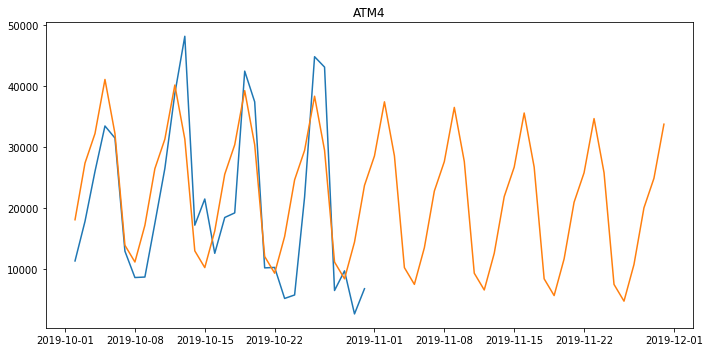

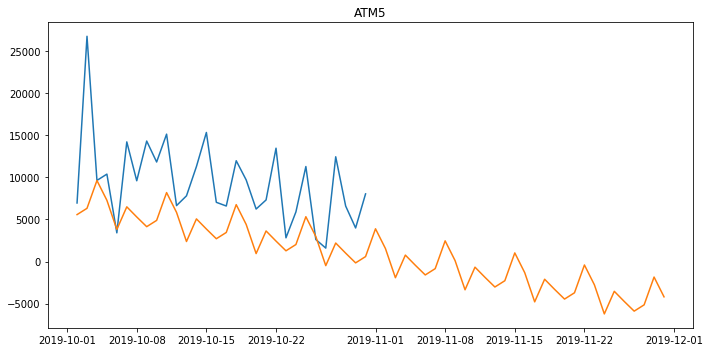

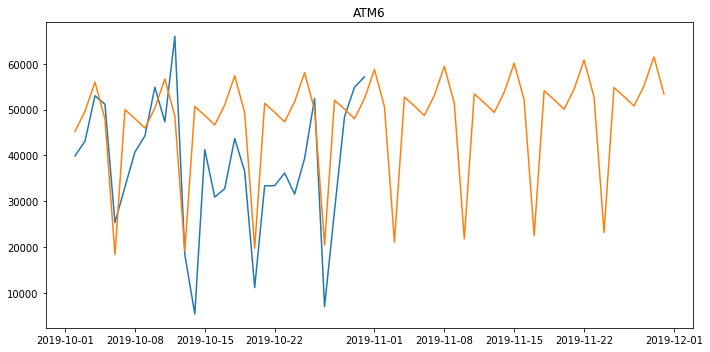

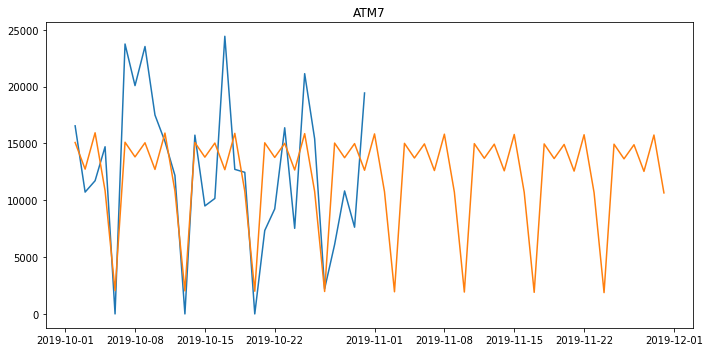

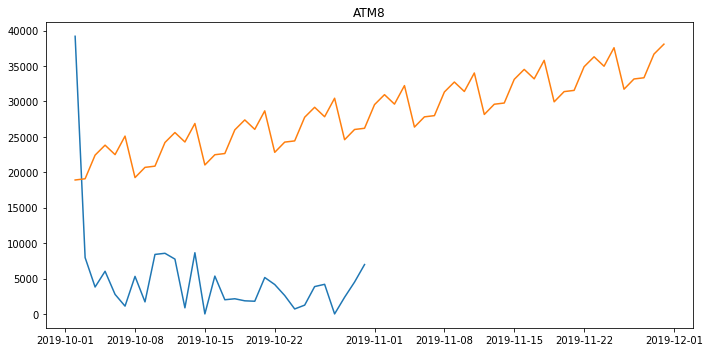

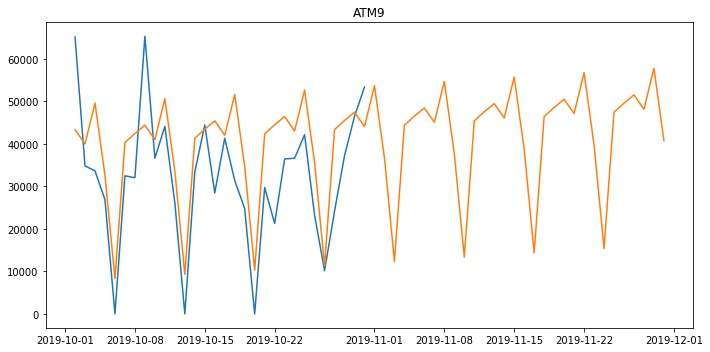

In [140]:
score = fitting()

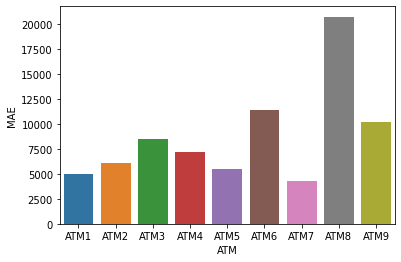

In [153]:
sns.barplot(data=score,x='ATM',y='MAE')

In [154]:
score

,ATM,MAE,MSE
0,ATM1,4949.671715,6.231403e+07
1,ATM2,6089.810809,6.066052e+07
2,ATM3,8510.828338,1.118171e+08
3,ATM4,7206.972493,7.607099e+07
4,ATM5,5487.930605,4.740487e+07
5,ATM6,11394.099749,2.098226e+08
6,ATM7,4307.005924,2.673193e+07
7,ATM8,20706.589835,4.462689e+08
8,ATM9,10160.757656,1.421087e+08
